# Train a CNN to identify layers from time domain samples
## This is designed to be efficient on macbook and not CUDA
The goal of this notebook is to act as a proof of concept. We aim to see whether a small and basic CNN can identify the number of layers in a multi-layered sample.  
The model is trained on THz-TDS data. These are a direct measurement of the electric field of a THz pulse having propagated through a sample.  
The data is generated using a Matrix Transfer approach.  
Once trained the model is assessed using an unseen dataset and accuracy is calculated.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score


In [2]:
class CNN1D(nn.Module):
    def __init__(self, input_channels=1, num_classes=3):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=5, padding=2)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = torch.mean(x, dim=2)  # Global average pooling
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    loss_values = []
    model.train()
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        total_steps = len(train_loader)
        
        # Initialize tqdm with a progress bar for each epoch
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
            for i, (inputs, labels) in enumerate(pbar):
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Backward pass and optimization
                loss.backward()
                optimizer.step()
                
                # Update tqdm with the current loss
                running_loss += loss.item()
                pbar.set_postfix(loss=running_loss / (i + 1))  # Update loss on progress bar
        
        # Store the loss after each epoch
        loss_values.append(running_loss / total_steps)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / total_steps:.4f}")
    
    return loss_values


In [3]:
# Load the dataset with weights_only=False
data = torch.load("data/Synthetic_data_60k.pt", weights_only=False)

# Extract components
synthetic_data = data["synthetic_data"]
material_params = data["material_params"]
num_layers = data["num_layers"]

print("Dataset loaded successfully!")
print(f"Number of samples: {len(synthetic_data)}")
print(f"Shape of synthetic_data: {synthetic_data.shape}")
print(f"Shape of num_layers: {num_layers.shape}")
print(f"Example number of layers: {num_layers[:10]}")

num_classes = int(max(num_layers)) # class labels start at 1 not 0.

Dataset loaded successfully!
Number of samples: 60000
Shape of synthetic_data: torch.Size([60000, 1024])
Shape of num_layers: torch.Size([60000])
Example number of layers: tensor([2, 1, 3, 3, 1, 3, 3, 3, 2, 2])


In [4]:
# Adjust labels for training (CrossEntropyLoss expects 0-based class labels)
num_layers_adjusted = num_layers - 1  # Convert labels from 1–5 → 0–4

# Ensure shapes are as expected
print("synthetic_data shape (after unsqueeze):", synthetic_data.unsqueeze(1).shape)
print("num_layers (original):", num_layers[:10])
print("num_layers_adjusted (for training):", num_layers_adjusted[:10])


synthetic_data shape (after unsqueeze): torch.Size([60000, 1, 1024])
num_layers (original): tensor([2, 1, 3, 3, 1, 3, 3, 3, 2, 2])
num_layers_adjusted (for training): tensor([1, 0, 2, 2, 0, 2, 2, 2, 1, 1])


In [5]:
# Adjust labels from 1–N to 0–(N-1)
num_layers_adjusted = num_layers - 1  # torch.Size([100])
num_classes = int(num_layers_adjusted.max().item()) + 1  # e.g., 5 if max label is 4

# Unsqueeze to add channel dimension for Conv1D input: [total samples, 1, 1024]
synthetic_data = synthetic_data.unsqueeze(1)  

# Create TensorDataset with adjusted labels
train_dataset = TensorDataset(synthetic_data, num_layers_adjusted)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

# Initialize the model, criterion, and optimizer
model = CNN1D(input_channels=1, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Optional: Print shapes and label stats for sanity check
print("Data shape:", synthetic_data.shape)
print("Label range:", num_layers_adjusted.min().item(), "to", num_layers_adjusted.max().item())
print("Number of classes:", num_classes)

Data shape: torch.Size([60000, 1, 1024])
Label range: 0 to 2
Number of classes: 3


In [6]:
# Train the model
train_loss = train_model(model, train_loader, criterion, optimizer, num_epochs=30, )


# Plot loss
plt.plot(train_loss, label='training')
plt.set_xlabel('Epochs')
plt.set_ylabel('Loss')
plt.set_title('Training Loss Progress')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/30: 100%|██████████| 235/235 [01:56<00:00,  2.01batch/s, loss=1.02]


Epoch [1/30], Loss: 1.0220


Epoch 2/30: 100%|██████████| 235/235 [01:58<00:00,  1.99batch/s, loss=0.914]


Epoch [2/30], Loss: 0.9140


Epoch 3/30: 100%|██████████| 235/235 [01:53<00:00,  2.07batch/s, loss=0.88] 


Epoch [3/30], Loss: 0.8804


Epoch 4/30: 100%|██████████| 235/235 [01:52<00:00,  2.08batch/s, loss=0.818]


Epoch [4/30], Loss: 0.8183


Epoch 5/30: 100%|██████████| 235/235 [02:00<00:00,  1.96batch/s, loss=0.731]


Epoch [5/30], Loss: 0.7311


Epoch 6/30: 100%|██████████| 235/235 [01:58<00:00,  1.98batch/s, loss=0.676]


Epoch [6/30], Loss: 0.6756


Epoch 7/30: 100%|██████████| 235/235 [01:59<00:00,  1.97batch/s, loss=0.629]


Epoch [7/30], Loss: 0.6288


Epoch 8/30: 100%|██████████| 235/235 [01:59<00:00,  1.96batch/s, loss=0.611]


Epoch [8/30], Loss: 0.6113


Epoch 9/30: 100%|██████████| 235/235 [01:59<00:00,  1.97batch/s, loss=0.619]


Epoch [9/30], Loss: 0.6191


Epoch 10/30: 100%|██████████| 235/235 [01:59<00:00,  1.96batch/s, loss=0.588]


Epoch [10/30], Loss: 0.5876


Epoch 11/30: 100%|██████████| 235/235 [01:59<00:00,  1.96batch/s, loss=0.578]


Epoch [11/30], Loss: 0.5783


Epoch 12/30: 100%|██████████| 235/235 [01:59<00:00,  1.96batch/s, loss=0.572]


Epoch [12/30], Loss: 0.5722


Epoch 13/30: 100%|██████████| 235/235 [01:58<00:00,  1.98batch/s, loss=0.564]


Epoch [13/30], Loss: 0.5643


Epoch 14/30: 100%|██████████| 235/235 [01:58<00:00,  1.98batch/s, loss=0.545]


Epoch [14/30], Loss: 0.5447


Epoch 15/30: 100%|██████████| 235/235 [01:59<00:00,  1.97batch/s, loss=0.55] 


Epoch [15/30], Loss: 0.5501


Epoch 16/30: 100%|██████████| 235/235 [01:57<00:00,  2.00batch/s, loss=0.55] 


Epoch [16/30], Loss: 0.5496


Epoch 17/30: 100%|██████████| 235/235 [01:57<00:00,  2.01batch/s, loss=0.549]


Epoch [17/30], Loss: 0.5487


Epoch 18/30: 100%|██████████| 235/235 [01:58<00:00,  1.99batch/s, loss=0.54] 


Epoch [18/30], Loss: 0.5397


Epoch 19/30: 100%|██████████| 235/235 [01:59<00:00,  1.97batch/s, loss=0.547]


Epoch [19/30], Loss: 0.5468


Epoch 20/30: 100%|██████████| 235/235 [01:59<00:00,  1.97batch/s, loss=0.535]


Epoch [20/30], Loss: 0.5345


Epoch 21/30: 100%|██████████| 235/235 [01:59<00:00,  1.97batch/s, loss=0.515]


Epoch [21/30], Loss: 0.5154


Epoch 22/30: 100%|██████████| 235/235 [01:59<00:00,  1.97batch/s, loss=0.521]


Epoch [22/30], Loss: 0.5208


Epoch 23/30: 100%|██████████| 235/235 [02:00<00:00,  1.95batch/s, loss=0.512]


Epoch [23/30], Loss: 0.5117


Epoch 24/30: 100%|██████████| 235/235 [01:59<00:00,  1.97batch/s, loss=0.508]


Epoch [24/30], Loss: 0.5078


Epoch 25/30: 100%|██████████| 235/235 [01:59<00:00,  1.97batch/s, loss=0.513]


Epoch [25/30], Loss: 0.5134


Epoch 26/30: 100%|██████████| 235/235 [01:58<00:00,  1.98batch/s, loss=0.512]


Epoch [26/30], Loss: 0.5116


Epoch 27/30: 100%|██████████| 235/235 [01:59<00:00,  1.97batch/s, loss=0.532]


Epoch [27/30], Loss: 0.5315


Epoch 28/30: 100%|██████████| 235/235 [01:59<00:00,  1.96batch/s, loss=0.516]


Epoch [28/30], Loss: 0.5164


Epoch 29/30: 100%|██████████| 235/235 [01:59<00:00,  1.97batch/s, loss=0.496]


Epoch [29/30], Loss: 0.4963


Epoch 30/30: 100%|██████████| 235/235 [01:55<00:00,  2.03batch/s, loss=0.487]

Epoch [30/30], Loss: 0.4874


ValueError: too many values to unpack (expected 5)


Training Accuracy: 0.8039


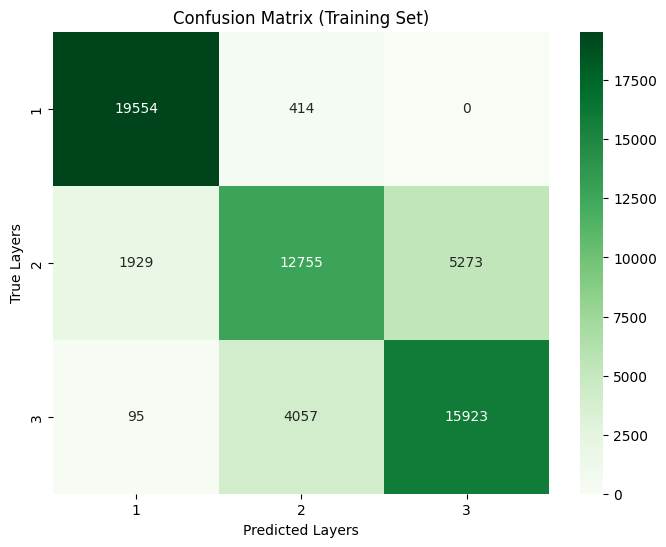

In [7]:
# Set model to evaluation mode
model.eval()
train_preds = []
train_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for inputs, labels in train_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

# Compute confusion matrix and accuracy for training set
train_cm = confusion_matrix(train_labels, train_preds)
train_acc = accuracy_score(train_labels, train_preds)

print(f"\nTraining Accuracy: {train_acc:.4f}")

# Plot confusion matrix for training set
plt.figure(figsize=(8, 6))
sns.heatmap(train_cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=[f"{i+1}" for i in range(train_cm.shape[0])],
            yticklabels=[f"{i+1}" for i in range(train_cm.shape[0])])
plt.xlabel("Predicted Layers")
plt.ylabel("True Layers")
plt.title("Confusion Matrix (Training Set)")
plt.show()

## Validate on unseen data


Validation Accuracy: 0.8012


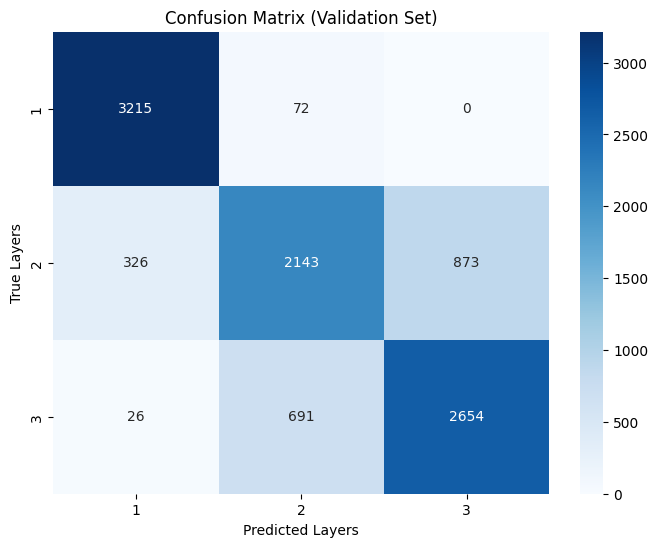

In [8]:
# Load the validation dataset
val_data = torch.load("data/Validation.pt", weights_only=False)

val_synthetic_data = val_data["synthetic_data"]         # shape: [N, 1024]
val_num_layers = val_data["num_layers"]                 # shape: [N]
val_num_layers_adjusted = val_num_layers - 1            # match training label indexing

# Unsqueeze to match model input shape
val_synthetic_data = val_synthetic_data.unsqueeze(1)    # shape: [N, 1, 1024]

# Create DataLoader for validation
val_dataset = TensorDataset(val_synthetic_data, val_num_layers_adjusted)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Set model to evaluation mode
model.eval()
all_preds = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix and accuracy
cm = confusion_matrix(all_labels, all_preds)
acc = accuracy_score(all_labels, all_preds)

print(f"\nValidation Accuracy: {acc:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"{i+1}" for i in range(cm.shape[0])],
            yticklabels=[f"{i+1}" for i in range(cm.shape[0])])
plt.xlabel("Predicted Layers")
plt.ylabel("True Layers")
plt.title("Confusion Matrix (Validation Set)")
plt.show()

Random Guessing Accuracy: 0.3352


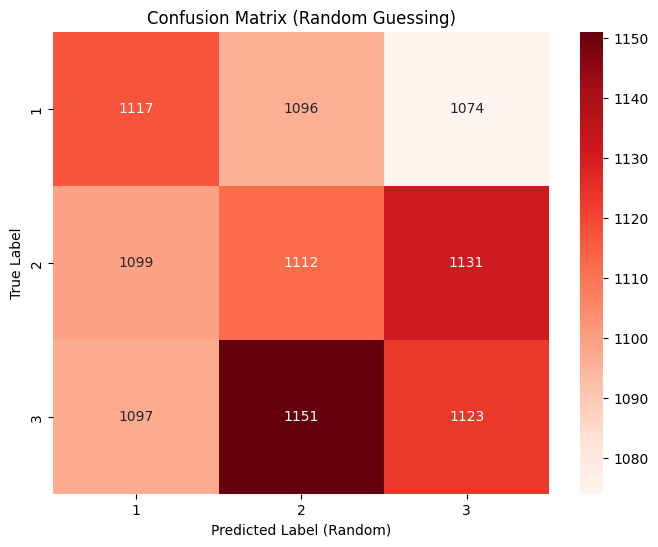

In [9]:
# Simulate random guessing based on the number of classes
num_classes = len(np.unique(all_labels))
random_guesses = np.random.choice(num_classes, size=len(all_labels))

# Compute accuracy and confusion matrix for random guesses
random_acc = accuracy_score(all_labels, random_guesses)
random_cm = confusion_matrix(all_labels, random_guesses)

print(f"Random Guessing Accuracy: {random_acc:.4f}")

# Plot confusion matrix for random guessing
plt.figure(figsize=(8, 6))
sns.heatmap(random_cm, annot=True, fmt="d", cmap="Reds",
            xticklabels=[f"{i+1}" for i in range(num_classes)],
            yticklabels=[f"{i+1}" for i in range(num_classes)])
plt.xlabel("Predicted Label (Random)")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Random Guessing)")
plt.show()